# # (IAT 460) Week 2 Lab — Part 2: Fractals

Credit: https://dcato98.github.io/blog/jupyter/visualization/python/cuda/numpy/pytorch/video/2020/04/28/CUDA-Accelerated-Julia-Fractals.html

## Setup

In [ ]:
!pip install torch matplotlib tqdm numpy ipywidgets

You can greatly speed up pytorch operations by using a gpu. If you are using colab, you can click on 'additional connection options' in the top right (next to the RAM and Disk usage display, and then select "change runtime type": 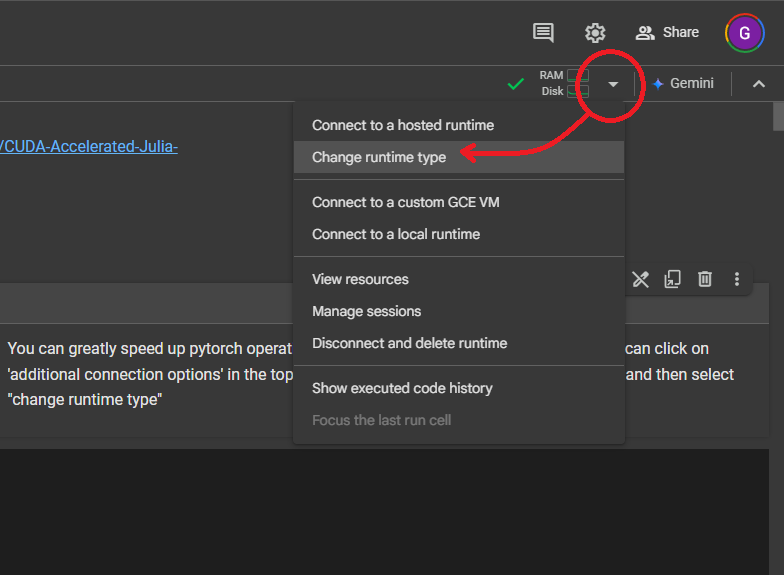



Then switch to a T4 GPU:

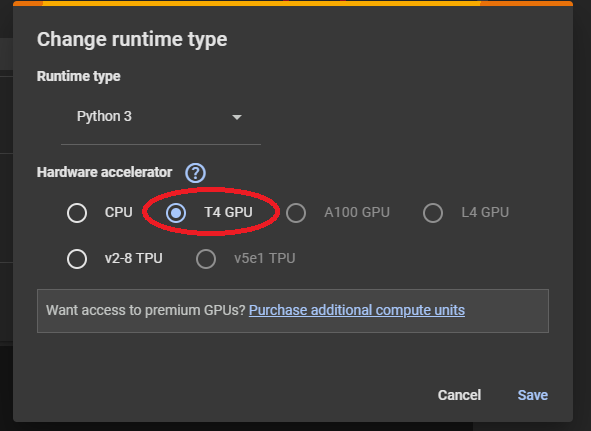

This code block will detect if you have a gpu available and set all the operations to use gpu or cpu accordingly:

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

# Julia Fractals

In the first section, you'll learn how to generate impressively cool images like the Mandelbrot set, both in NumPy and in PyTorch.

In the second section, you'll speed up your image generation by over a factor of 10, learning about broadcasting and the speedups that come from maxing out the GPU.

In the third section, you'll generate mesmerizing videos exploring the very fabric of Julia fractal-space.

### Hang on...what is a Julia fractal?

Steven Wittens does an incredible job of showing what a Julia set is in his post [How to Fold a Julia Fractal](http://acko.net/blog/how-to-fold-a-julia-fractal/). If you need a refresher on Julia sets, or just want to marvel at Witten's impressive ability to build intuition through evocative visualizations, I suggest you take a few minutes to check it out now. Then return when you're ready to start coding.

## Part 1: From Math to Code

A Julia fractal is computed by iteratively applying a function over a set of points in the complex plane. Mathematically, this looks like:

$$ z_{n+1} = f_n(z_n, c) $$

Where $ f $ is a complex, non-linear function (i.e. map) and $ z_0 $ and $ c $ are both complex numbers.

By applying these maps iteratively over the points in the complex plane, the points that diverge to infinity are excluded from the Julia set. Those that don't diverge are part of the set.

### Defining the complex plane

Let's get started defining the region of the complex plane we want to plot (`xrange` and `yrange`), as well as the `resolution` of our image.

In [ ]:
xrange = yrange = (-2, 2)
resolution = (5, 5) # (x-resolution, y-resolution)

Each point corresponds to one pixel, so in this case, we'll end up with a 5x5 pixel image with 25 points evenly spaced in the grid defined by the real x-axis ranging from -2 to 2, and the imaginary y-axis ranging from -2i to 2i.

This fully specifies our complex plane. Let's create this with PyTorch:

In [ ]:
import torch

def complex_plane(xrange=(-2,2), yrange=None, res=1000, device='cuda'):
    '''Return a 2-tuple of grids corresponding to the real and imaginary points
    on the complex plane, respectively.'''
    if yrange == None: yrange = xrange
    if type(res) == int: res = (res,res)

    # np.linspace(...) --> torch.linspace(...).cuda()
    x = torch.linspace(xrange[0], xrange[1], res[0]).to(device)
    y = torch.linspace(yrange[1], yrange[0], res[1]).to(device)

    # np.meshgrid --> torch.meshgrid
    real_plane, imag_plane = torch.meshgrid(x,y)

    cplane = tuple([real_plane.transpose(0,1), imag_plane.transpose(0,1)])

    return cplane

In [ ]:
complex_plane(xrange, yrange, resolution, device)

### Defining divergence

Now that we have our complex plane, we need to know how to detect whether a point has diverged. This will determine what color we plot it.

Of course, we don't have an infinitely sized numeric data type to determine whether a point has 'reached infinity' yet. On top of this, we don't have an infinite amount of time to find out whether each point exceeds this bound.

One way to approximate this is to count how many iterations it takes before a point exceeds a specified `divergence_value`, up to a fixed number of iterations, `n_iterations`.

In [ ]:
divergence_value = 2
n_iterations = 50

`n_iterations` is an especially convenient parameter because it directly manages our tradeoff between time and accuracy. More iterations take longer to compute, but result in higher quality maps.

### Choosing a mapping function

Now that we know how to count convergence, we just need to choose a map. Let's recall our generating function:

$$ z_{n+1} = f_n(z_n, c) $$

We'll spend most of our time here working with the most popular function for generating Julia fractals, the quadratic map:

$$ f(z) = z^2 + c $$

Two other popular choices are the sine map (implemented at the very end) and cosine map (left as an exercise for the reader):

$$ f(z) = c * sin(z) $$
$$ f(z) = c * cos(z) $$

Let's start by implementing the quadratic map in PyTorch:

In [ ]:
def complex_magnitude(r,i):
    '''returns the magnitude of a complex tensor, given a real component, `r`, and an imaginary component, `i`'''
    return torch.sqrt(r**2+i**2)

def quadratic(z, c):
    return (z[0]**2-z[1]**2 + c[0], # real
        2*z[0]*z[1] + c[1])     # imaginary

def quadratic_method(c, z, n_iterations, divergence_value, map = quadratic, device='cuda'):
    '''Iteratively apply the quadratic map `z = z^2 + c` for `n_iterations` times
        c: tuple of the real and imaginary components of the constant value
        z: tuple of the real and imaginary components of the initial z-value
    '''
    # np.zeros_like(...) --> torch.zeros_like(...).cuda()
    stable_steps = torch.zeros_like(z[0]).to(device)

    for _ in range(n_iterations):
        # numpy handled squaring complex magnitudes, for PyTorch we implement this ourselves

        mask = torch.lt(complex_magnitude(*z), divergence_value).to(device)
        stable_steps += mask.to(torch.float32)

        # likewise, we manually implement one iteration of the quadratic map
        #z = (z[0]**2-z[1]**2 + c[0], # real
        #     2*z[0]*z[1] + c[1])     # imaginary
        z = map(z, c)

    # don't forget to put the array onto the cpu for plotting!
    return stable_steps / n_iterations

Finally, to visually verify our model, let's choose a value for `c` for which the image is already known. Paul Bourke lists of some particularly interesting on his [website](http://paulbourke.net/fractals/juliaset/). I like $ c = 0.54 + 0.54i $, which, according to Bourke's website, looks like this:

![dragon-fractal](http://paulbourke.net/fractals/juliaset/sample4s.png)

In [ ]:
c = [-0.54, 0.54]

z_init = complex_plane(xrange, yrange, resolution, device=device)

img = quadratic_method(c, z_init, n_iterations, divergence_value, device=device)
img

### Plotting a Julia set

This is difficult to inspect by eye. Let's write a function to plot these values. By experimentation, I've found that plotting the negative log of the returned values usually gives a nice contrast of values. `eps` controls the sensitivity to values very close to zero.

In [ ]:
import matplotlib.pyplot as plt

def plot_julia(julia_img, sz=16, eps=.1):
    img = -torch.log(julia_img + eps)
    img = img.cpu()
    plt.figure(figsize=(sz,sz))
    plt.imshow(img)
    plt.show()

In [ ]:
plot_julia(img, sz=6)

Hmm...looks like we don't have enough resolution to get a clear picture.

In [ ]:
resolution = 64

c = [-0.54, 0.54]
z_init = complex_plane(xrange, yrange, resolution, device=device)
img = quadratic_method(c, z_init, n_iterations, divergence_value, device=device)
plot_julia(img, sz=6)

This is looking promising! Let's increase the resolution even further, and make the image bigger for a better comparison.

In [ ]:
resolution = 1024

c = [-0.54, 0.54]
z_init = complex_plane(xrange, yrange, resolution, device)
img = quadratic_method(c, z_init, n_iterations, divergence_value, device=device)
plot_julia(img, sz=12)

We're starting to get very close to the original, but we're lacking in detail. Let's increase how many iterations we do from 50 to 200 iterations.

In [ ]:
n_iterations = 200

c = [-0.54, 0.54]
z_init = complex_plane(xrange, yrange, resolution, device)
img = quadratic_method(c, z_init, n_iterations, divergence_value, device=device)
plot_julia(img, sz=12)

Looks like the same fractal to me!

And along the way, we've seen how to improve the quality of our generated images by increasing the image resolution and/or increasing the number of iterations.

So we used a constant value for `c` to create this image, but the famous Mandelbrot set is generated by varying `c`, setting it equal the complex plane. That is, `c` varies for each point in the plane, so that `c` is equal to the coordinate at that point.

We can actually already do this, using the same function we use to initialize the complex plane! Let's test it out:

In [ ]:
# Mandelbrot set
c = complex_plane(xrange, yrange, resolution, device)

z_init = complex_plane(xrange, yrange, resolution, device)
img = quadratic_method(c, z_init, n_iterations, divergence_value, device=device)
plot_julia(img, sz=6)

## Part 2: Broadcasting - From One to Many

This tiny change illustrates the power of broadcasting. Broadcasting is what makes this so amazingly efficient. If you've never heard of broadcasting, [here's](https://medium.com/ai%C2%B3-theory-practice-business/broadcasting-in-pytorch-numpy-36bbdef22dff) a good place to review it. Skip to the section on 'Broadcasting Rules' if just need a quick refresher. Take all the time you need, I'm not going anywhere.

Good? Good.

### Updating the data model

So, what area is a good candidate for speeding up? We can't easily parallelize the calculation of an image any further due to the iterative nature of the calculation. However, we *can* compute multiple images in parallel.

Right now, we're generating 1 image, in 2 dimensions (x, y). This is defined by our variable, `resolution`, and is reflected in the shape of our constant, `c`, and $ z_0 $ ,  `z_init`.

In [ ]:
resolution, c[0].shape, z_init[0].shape

One way to do this is to vary our complex constant, `c`, generating multiple images. For example, we can add a new dimension in front, describing how many images to calculate at once, sampling `c` along the complex plane. I'll refer to this as the *grid* of images.

I'll demonstrate this directly in PyTorch to get the immediate speed advantages, although it is straightforward to transcribe into NumPy.

In [ ]:
# number of images in x and y directions
grid_resolution = 5

# sample c evenly between these values
grid_xrange = grid_yrange = [-2, 2]

# number of pixels in each image
image_resolution = 64

# range of complex valued points in each image
image_xrange = image_yrange = [-2, 2]

# take note the dimensions here
c_real, c_imag = [ri.reshape(grid_resolution, grid_resolution, 1, 1)
                  for ri in complex_plane(grid_xrange, grid_yrange, grid_resolution, device)]

# take note of the dimensions here
z_real, z_imag = [ri.reshape(1, 1, image_resolution, image_resolution)
                  for ri in complex_plane(image_xrange, image_yrange, image_resolution, device)]

c_real.shape, z_real.shape

Now look at the resulting shape when we add `c` to `z`:

In [ ]:
(c_real + z_real).shape

The way to interpret this is that we're *broadcasting* the initialization of the complex plane, `z`, across every individual value of `c`, effectively representing a 5x5 grid of images, each with dimension 64x64. The image at [0,0,:,:] will represent the top-left-most value of `c`, which according to `grid_xrange` and `grid_yrange` is $ c = -2 + 2i $.

If you don't follow this yet, don't worry! Note your confusion, continue reading, and circle back after seeing what we're going to do with this. This is not easy to follow, but I ask that you please trust me, we're nearly there and it will all make sense very soon.

Let's generalize the creation of `c` and `z`.

In [ ]:
def make_cz_grids(grid_res, img_res, grid_x_rng=(-2,2), grid_y_rng=(-2,2), img_x_rng=(-2,2), img_y_rng=(-2,2), device='cuda'):
    if type(grid_res) == int: grid_res = (grid_res, grid_res)
    if type(img_res ) == int: img_res  = (img_res , img_res )
    c = [x.reshape(grid_res[0],grid_res[1],1,1) for x in complex_plane(grid_x_rng, grid_y_rng, grid_res, device)]
    z = [x.reshape(1,1,img_res[0],img_res[1]) for x in complex_plane(img_x_rng, img_x_rng, img_res, device)]
    return c,z

In [ ]:
c, z = make_cz_grids(grid_resolution, image_resolution, device=device)

(c[0] + z[0]).shape

Now that we've updated our variables, let's update our method. Note that, because of broadcasting, we only need to change one line of code.

### Updating the iteration method

I suggest you take a moment to read through this function to convince yourself that this will work.

In [ ]:
def quadratic_method(c, z, n_iterations, divergence_value, map = quadratic, device='cuda'):
    '''Iteratively apply the quadratic map `z = z^2 + c` for `n_iterations` times
        c: tuple of the real and imaginary components of the constant value
        z: tuple of the real and imaginary components of the initial z-value
    '''
    # add c[0] to get the right shape
    stable_steps = torch.zeros_like(c[0] + z[0]).to(device)

    for i in range(n_iterations):
        mask = torch.lt(complex_magnitude(*z), divergence_value)
        stable_steps += mask.to(torch.float32)
        z = map(z, c)
    return stable_steps / n_iterations

*This* is but a small taste of the power and the beauty of broadcasting. Once we set up an appropriate data model, we get parallelization for free.

Time to test this out.

In [ ]:
n_iterations = 50
c, z = make_cz_grids(grid_resolution, image_resolution, device=device)
imgs = quadratic_method(c, z, n_iterations, divergence_value, device=device)
imgs.shape

This is the output shape we expected. Now let's plot these images!

### Plotting a grid of Julia sets

In [ ]:
def plot_julia_grid(images, figsize=(12,12)):
    rows, cols = images.shape[:2]
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(images[i,j].cpu())
            axs[i,j].get_xaxis().set_visible(False)
            axs[i,j].get_yaxis().set_visible(False)
    plt.show()

In [ ]:
plot_julia_grid(imgs)

This is a start, but it's not quite clear yet whether we've actually done it right. Let's try increasing the resolution of our grid and zoom in on the appropriate region.

In [ ]:
# this is the main region where the Mandelbrot set exists
#   and also happens to be where the Julia sets are connected
grid_x_rng = (-1.5, 0.5)
grid_y_rng = (-1, 1)
grid_resolution = 21
image_resolution = 512

c, z = make_cz_grids(grid_resolution, image_resolution, grid_x_rng=grid_x_rng, grid_y_rng=grid_y_rng, device=device)
imgs = quadratic_method(c, z, n_iterations, divergence_value, device=device)
plot_julia_grid(imgs, figsize=(16,16))

This looks pretty good!

And what does one of these images look like?

In [ ]:
x = 15
y = 2

print(f'c = {c[0][y][x][0][0]:0.3f} + {c[1][y][x][0][0]:0.3f}i')
plot_julia(imgs[y, x], sz=8)

## Part 3: Visualizing the Julia set as a video

To create the video we'll be using `ffmpeg`. If you want to follow along with this section, make sure you have it installed. I'd suggest a link, but installation varies across platforms so I'll leave you to search for instructions relevant to your situation.

### Preparing the video frames

For this video, let's visualize varying `c` along the real x-axis, holding the imaginary y-axis constant at 0.25i.

First, we'll use the code we've already written to generate our frames. If your GPU runs out of memory at this point, try decreasing either the image resolution or the number of frames.

One way to get around this and create large videos at high quality would be to create and save the images in smaller batches before creating video (don't forget to name the frames in sequence!).

In [ ]:
# vary the c-values along the x-axis
grid_x_rng = (-1.5, 0.5)

# hold the y-axis constant
grid_y_rng = (0.25, 0.25)

# define number of frames
grid_resolution = (120, 1)

# image quality parameters
image_resolution = 1024
n_iterations = 200

c, z = make_cz_grids(grid_resolution, image_resolution, grid_x_rng, grid_y_rng, device=device)
imgs = quadratic_method(c, z, n_iterations, divergence_value, device=device).cpu()

# temporarily reshape our images into a square grid to easily visualize our frames
plot_julia_grid(imgs.reshape(10,12,image_resolution, image_resolution), figsize=(16,16))

Looks good. Now let's smoosh together the grid, treating `imgs` as a list, not a grid, of images.

In [ ]:
imgs = imgs.reshape(-1, image_resolution, image_resolution)
imgs.shape

Next let's set up our file paths.

We need a working directory, `path`, a subfolder in this location for saving a the list of images, `frame_folder`, and a filename which we'll name the video, `video_fn`.

-- **Remember, in colab, your files will be to the left in the files tab** --

In [ ]:
from pathlib import Path

# set this to your preferred working directory
path = Path('outputs')

frame_folder = path / f'julia_frames'

# save the video here
# video_fn = path / 'julia_visualization.mp4' # for some reason, I couldn't play .mp4 files in the notebook
video_fn = path / 'julia_visualization.webm' # MUCH slower to convert, also it looks like it might be resolution, try mp4 first

# create the frame folder
frame_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
from tqdm import tqdm

# save images into the frame folder, this can take a while
for i, img in tqdm(enumerate(imgs), total=len(imgs)):
    fig = plt.figure(figsize=(16,16))
    plt.imshow(img)

    # turn off axis ticks
    plt.xticks([])
    plt.yticks([])

    # save image to `frame_folder` directory
    plt.savefig(frame_folder / f'julia_{i:08d}.png')
    # prevent plot from displaying in notebook, also reduces memory use
    plt.close(fig)

### Creating a video

In [ ]:
# set the frame rate
fps = 30  # fps=frames per second

# change working directory to the frame folder
old_wd = Path.cwd()
frame_folder.cwd()

image_path_format = frame_folder / 'julia_%08d.png'

# create video
#! ffmpeg -r $fps -i $image_path_format -pix_fmt yuv420p -y $video_fn
! ffmpeg -r $fps -i $image_path_format -y $video_fn

# return to old working directory
old_wd.cwd()

### Playing our video

This needs no explanation. Sit back and enjoy :)

In [ ]:
from ipywidgets import Video

Video.from_file(video_fn)

## What's next?

There are so many fun directions to go from here! Here's a few ideas:
 - Colorization: Try experimenting with different thresholds, multiple colors, etc... A quick google search turns up many amazing examples. Can you replicate these? Can you invent your own? In matplotlib, you can pick different color maps [docs](https://matplotlib.org/stable/users/explain/colors/colormaps.html)
 - Map: There's nothing inherently special about the quadratic map. It's well studied, but try exploring fractals made from another map.
 - Video: Instead of updating `c` in a line, consider updating `c` to travel in a circle or other continuous curve. Or, continuously zoom in on a particularly interesting patch.
 - 3D: Our image grid and video are 2 ways to try to grasp the shape of a 4D object. What would this object look like in 3D (say, by holding the real or imaginary component of `c` constant). Then, create a video of the 3D object as you travel along the 4th dimension.
 - Batching: Occasionally when I wrote this, I experimented with large parameters which caused the GPU to run out of memory (e.g. when creating the video) and requiring the notebook to be restarted - batching what gets sent to the GPU could prevent this from happening.

For a bit of inspiration, here's an example of experimenting with colorization and maps to generate "electric christmas trees" Set is(see image below) generated using the Sine map!

First, I've refactored our code a bit to make our Julia generator and plotting functions more generic:

In [ ]:
# implement the quadratic and Sine maps for complex numbers
def quadratic_map(c, z): return (z[0]**2-z[1]**2 + c[0], 2*z[0]*z[1] + c[1])

# modify our quadratic julia method to generalize to any mapping function
def julia_generator(c=None, z=None, n_iterations=50, divergence_value=50, map_func=quadratic_map, device='cuda'):
    '''A generic julia fractal generator (defaults produce the Mandelbrot set).'''
    if c is None: c = complex_plane(device=device)
    if z is None: z = complex_plane(device=device)
    stable_steps = torch.zeros_like(c[0]+z[0]).to(device)
    for i in range(n_iterations):
        mask = torch.lt(z[1].abs(), divergence_value)
        stable_steps += mask.to(torch.float32)
        z = map_func(c, z)
    return (stable_steps / n_iterations).cpu()

# add `transform_func` to our standard plotting function to accept arbitrary image transformations
def plot_julia(julia_img, sz=16, eps=.1, transform_func=None):
    img = -torch.log(julia_img + eps) if transform_func is None else transform_func(julia_img)
    plt.figure(figsize=(sz,sz))
    plt.imshow(img.cpu(), cmap="viridis")
    plt.show()

Testing the default Julia generator:

In [ ]:
plot_julia(julia_generator())

Now, we implement the Sine map. Look how easy this is with our newly refactored code!

In [ ]:
# implementing the Sine map in PyTorch
def complex_mult(ar,ai,br,bi): return (ar*br-ai*bi, ar*bi+ai*br)
def complex_sin(r,i): return (torch.sin(r)*torch.cosh(i), torch.sinh(i)*torch.cos(r))
def sin_map(c, z): return complex_mult(*complex_sin(*z), *c)

After exploring the Sine map, this is one of my favorites!

In [ ]:
# parameters for the Electric Christmas Trees fractal
map_func = sin_map
c = [1.0, 0.1]
xrange = yrange = (-5,5)
print('Electric Christmas Trees! (Sine map: c = 1.0 + 0.1i)')

# image quality parameters
resolution = 1024
n_iterations = 256
figsize = 16
tranform_func = lambda x: x   # don't transform the output, default is do: -log(julia_img)

# putting it all together!
z = complex_plane(xrange, yrange, resolution)
img = julia_generator(c, z, n_iterations, divergence_value, map_func=map_func)
plot_julia(img, sz=figsize, transform_func=tranform_func)

### More mapping functions!

In [ ]:
def complex_add(ar, ai, br, bi):
    return ar + br, ai + bi

def complex_mult(ar, ai, br, bi):
    return ar*br - ai*bi, ar*bi + ai*br

def complex_square(r, i):
    return complex_mult(r, i, r, i)

def complex_abs2(r, i):
    return r*r + i*i

In [ ]:
def cubic_map(c, z):
    z2 = complex_square(*z)
    z3 = complex_mult(*z2, *z)
    return complex_add(*z3, *c)

z = complex_plane(xrange, yrange, resolution)
img = julia_generator(c, z, n_iterations, divergence_value, map_func=cubic_map)
plot_julia(img, sz=figsize, transform_func=tranform_func)

In [ ]:
def exp_map(c, z):
    r, i = z
    exp_r = torch.exp(r)
    zr = exp_r * torch.cos(i)
    zi = exp_r * torch.sin(i)
    return complex_add(zr, zi, *c)

z = complex_plane(xrange, yrange, resolution)
img = julia_generator(c, z, n_iterations, divergence_value, map_func=exp_map)
plot_julia(img, sz=figsize, transform_func=tranform_func)

In [ ]:
def scaled_quadratic_map(c, z, alpha=1.0):
    z2 = complex_square(*z)
    return complex_add(alpha*z2[0], alpha*z2[1], *c)

z = complex_plane(xrange, yrange, resolution)
img = julia_generator(c, z, n_iterations, divergence_value, map_func=scaled_quadratic_map)
plot_julia(img, sz=figsize, transform_func=tranform_func)

In [ ]:
def hybrid_map(c, z, a=3.0, b=0.3):
    z2 = complex_square(*z)
    lin = complex_mult(a, 0.0, *z)
    nonlin = complex_mult(b, 0.0, *z2)
    return complex_add(*lin, *nonlin)

z = complex_plane(xrange, yrange, resolution)
img = julia_generator(c, z, n_iterations, divergence_value, map_func=hybrid_map)
plot_julia(img, sz=figsize, transform_func=tranform_func)

In [ ]:
def rotated_square_map(c, z, theta=torch.tensor(0.3)):
    zr, zi = z
    rot = (
        zr*torch.cos(theta) - zi*torch.sin(theta),
        zr*torch.sin(theta) + zi*torch.cos(theta)
    )
    z2 = complex_square(*rot)
    return complex_add(*z2, *c)

z = complex_plane(xrange, yrange, resolution)
img = julia_generator(c, z, n_iterations, divergence_value, map_func=rotated_square_map)
plot_julia(img, sz=figsize, transform_func=tranform_func)

In [ ]:
def abs_square_map(c, z):
    zr, zi = torch.abs(z[0]), torch.abs(z[1])
    z2 = complex_square(zr, zi)
    return complex_add(*z2, *c)

z = complex_plane(xrange, yrange, resolution)
img = julia_generator(c, z, n_iterations, divergence_value, map_func=abs_square_map)
plot_julia(img, sz=figsize, transform_func=tranform_func)

### Design Template

In [ ]:
def my_map(c, z, param1=..., param2=...):
    # 1. transform z
    zr, zi = ...

    # 2. apply nonlinearity
    zr2, zi2 = ...

    # 3. mix with c
    return zr2 + c[0], zi2 + c[1]